In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA

np.random.seed(42)

from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker

In [12]:

def load_data(data_path: str = 'data/filtered'):
    data_path = Path(data_path)
    
    movies_df = pd.read_csv(data_path / 'movies.csv')
    actors_df = pd.read_csv(data_path / 'actors.csv')
    directors_df = pd.read_csv(data_path / 'directors.csv')
    studios_df = pd.read_csv(data_path / 'studios.csv')
    
    poster_embeddings = np.load(data_path / 'poster_embeddings.npy')
    tagline_embeddings = np.load(data_path / 'tagline_embeddings.npy')
    description_embeddings = np.load(data_path / 'description_embeddings.npy')
    
    return movies_df, actors_df, directors_df, studios_df, poster_embeddings, tagline_embeddings, description_embeddings

In [13]:
def create_features(movies_df, actors_df, directors_df, studios_df):

    features = movies_df[['movie_id']].copy()
    
    # normalize numerical features
    features['year'] = movies_df['date']
    features['runtime'] = movies_df['minute']
    features['year_normalized'] = (features['year'] - features['year'].mean()) / features['year'].std()
    features['runtime_normalized'] = (features['runtime'] - features['runtime'].mean()) / features['runtime'].std()
    
    # one-hot encoding age rating
    age_dummies = pd.get_dummies(movies_df['theatrical_release_age_rating'], prefix='age_rating', dummy_na=True)
    features = pd.concat([features, age_dummies], axis=1)
    
    # encoding actors, directors, studios as binary features
    top_actors = actors_df['actor_name'].value_counts().head(50).index.tolist()
    actor_matrix = actors_df[actors_df['actor_name'].isin(top_actors)].groupby(
        ['movie_id', 'actor_name']
    ).size().unstack(fill_value=0)
    actor_matrix.columns = [f'actor_{c}' for c in actor_matrix.columns]
    features = features.merge(actor_matrix, on='movie_id', how='left').fillna(0)
    
    top_directors = directors_df['director_name'].value_counts().head(30).index.tolist()
    director_matrix = directors_df[directors_df['director_name'].isin(top_directors)].groupby(
        ['movie_id', 'director_name']
    ).size().unstack(fill_value=0)
    director_matrix.columns = [f'director_{c}' for c in director_matrix.columns]
    features = features.merge(director_matrix, on='movie_id', how='left').fillna(0)
    
    top_studios = studios_df['studio'].value_counts().head(20).index.tolist()
    studio_matrix = studios_df[studios_df['studio'].isin(top_studios)].groupby(
        ['movie_id', 'studio']
    ).size().unstack(fill_value=0)
    studio_matrix.columns = [f'studio_{c}' for c in studio_matrix.columns]
    features = features.merge(studio_matrix, on='movie_id', how='left').fillna(0)
    
    # aggregate features
    features['n_actors'] = actors_df.groupby('movie_id').size().reindex(features['movie_id']).fillna(0).values
    features['n_directors'] = directors_df.groupby('movie_id').size().reindex(features['movie_id']).fillna(0).values
    features['n_studios'] = studios_df.groupby('movie_id').size().reindex(features['movie_id']).fillna(0).values
    
    return features

In [14]:
def reduce_embedding_dimensions(embeddings, n_components=50, name='embedding'):

    pca = PCA(n_components=n_components, random_state=42)
    reduced = pca.fit_transform(embeddings)
    
    _ = pca.explained_variance_ratio_.sum()
    
    return reduced, pca

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, cv_folds=5):
    cv_rmse = cross_val_score(model, X_train, y_train, cv=cv_folds, scoring='neg_root_mean_squared_error')
    cv_r2 = cross_val_score(model, X_train, y_train, cv=cv_folds, scoring='r2')
    
    # Train on full training set
    model.fit(X_train, y_train)
    
    # Evaluate on test set
    y_pred = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_mae = mean_absolute_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)
    
    print(f"\n{model_name}:")
    print(f"  CV RMSE: {-cv_rmse.mean():.4f} (+/- {cv_rmse.std():.4f})")
    print(f"  CV R²:   {cv_r2.mean():.4f}")
    print(f"  Test RMSE: {test_rmse:.4f}")
    print(f"  Test MAE:  {test_mae:.4f}")
    print(f"  Test R²:   {test_r2:.4f}")
    
    return {
        'model_name': model_name,
        'cv_rmse': -cv_rmse.mean(),
        'cv_r2': cv_r2.mean(),
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_r2': test_r2
    }, model, y_pred


def train_modality_models(X_train, y_train, X_test, y_test, X_train_scaled, X_test_scaled, modality_name):

    print(f"\n{'='*60}")
    print(f"{modality_name.upper()} MODALITY")
    print('='*60)
    
    results = []
    models = {}

    ridge = Ridge(alpha=1.0)
    res, model, _ = evaluate_model(ridge, X_train_scaled, y_train, X_test_scaled, y_test, 'Ridge Regression')
    results.append(res)
    models['ridge'] = model
   
    gb = GradientBoostingRegressor(n_estimators=50, max_depth=5, learning_rate=0.1, random_state=42)
    res, model, pred = evaluate_model(gb, X_train, y_train, X_test, y_test, 'Gradient Boosting')
    results.append(res)
    models['gb'] = model
    
    if 'text' in modality_name.lower() or 'image' in modality_name.lower():
        mlp = MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=300, early_stopping=True, 
                          random_state=42, learning_rate_init=0.001)
        res, model, pred = evaluate_model(mlp, X_train_scaled, y_train, X_test_scaled, y_test, 'MLP Neural Network')
        results.append(res)
        models['mlp'] = model
    
    return results, models


def late_fusion_stacking(X_cat_train, X_text_train_s, X_image_train_s, y_train,
                         X_cat_test, X_text_test_s, X_image_test_s, y_test):

    # Get out-of-fold predictions for training (prevents leakage)
    print("\nGenerating out-of-fold predictions...")
    pred_cat_train = cross_val_predict(
        GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42),
        X_cat_train, y_train, cv=5
    )
    pred_text_train = cross_val_predict(
        MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=500, early_stopping=True, random_state=42),
        X_text_train_s, y_train, cv=5
    )
    pred_image_train = cross_val_predict(
        MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=500, early_stopping=True, random_state=42),
        X_image_train_s, y_train, cv=5
    )
    
    # Create stacked feature matrix for training
    X_stack_train = np.column_stack([pred_cat_train, pred_text_train, pred_image_train])
    
    # Fit final models to get test predictions
    model_cat = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42).fit(X_cat_train, y_train)
    model_text = MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=500, early_stopping=True, random_state=42).fit(X_text_train_s, y_train)
    model_image = MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=500, early_stopping=True, random_state=42).fit(X_image_train_s, y_train)
    
    pred_cat_test = model_cat.predict(X_cat_test)
    pred_text_test = model_text.predict(X_text_test_s)
    pred_image_test = model_image.predict(X_image_test_s)
    
    X_stack_test = np.column_stack([pred_cat_test, pred_text_test, pred_image_test])
    
    # train meta-learner
    meta_learner = Ridge(alpha=1.0)
    results, _, y_pred = evaluate_model(meta_learner, X_stack_train, y_train, X_stack_test, y_test, 'Stacking Ensemble')
    
    print(f"\nMeta-learner weights: {meta_learner.coef_}")
    print("  (Weights correspond to: [Cat/Num, Text, Image])")
    
    return results, meta_learner, y_pred, (pred_cat_test, pred_text_test, pred_image_test)


def early_fusion(X_cat_train_s, X_text_train_s, X_image_train_s, y_train,
                 X_cat_test_s, X_text_test_s, X_image_test_s, y_test):

    # Concatenate all feature matrices
    X_combined_train = np.concatenate([X_cat_train_s, X_text_train_s, X_image_train_s], axis=1)
    X_combined_test = np.concatenate([X_cat_test_s, X_text_test_s, X_image_test_s], axis=1)
    
    print(f"Combined feature matrix shape: {X_combined_train.shape}")
    
    results = []
    
    # Ridge: regularization for high-dim data, linear and suitable for tabular data
    ridge = Ridge(alpha=10.0)
    res, _, _ = evaluate_model(ridge, X_combined_train, y_train, X_combined_test, y_test, 'Ridge (Early Fusion)')
    results.append(res)
    
    # MLP: can learn more complex cross-modal interactions, good for embeddings
    mlp = MLPRegressor(hidden_layer_sizes=(256, 128, 64), max_iter=500, early_stopping=True, 
                       random_state=42, learning_rate_init=0.001)
    res, _, y_pred = evaluate_model(mlp, X_combined_train, y_train, X_combined_test, y_test, 'MLP (Early Fusion)')
    results.append(res)
    
    # Gradient Boosting, good for nonlinear relations and feature interactions
    gb = GradientBoostingRegressor(n_estimators=150, max_depth=5, learning_rate=0.05, random_state=42)
    res, _, _ = evaluate_model(gb, X_combined_train, y_train, X_combined_test, y_test, 'GB (Early Fusion)')
    results.append(res)
    
    return results, y_pred

In [15]:
movies_df, actors_df, directors_df, studios_df, poster_emb, tagline_emb, desc_emb = load_data()
cat_num_features = create_features(movies_df, actors_df, directors_df, studios_df)
print(f"features shape: {cat_num_features.shape}")

poster_reduced, _ = reduce_embedding_dimensions(poster_emb, n_components=50, name='Poster')
tagline_reduced, _ = reduce_embedding_dimensions(tagline_emb, n_components=50, name='Tagline')
desc_reduced, _ = reduce_embedding_dimensions(desc_emb, n_components=50, name='Description')

features shape: (10599, 115)


In [16]:
# Combine text embeddings
text_features = np.concatenate([tagline_reduced, desc_reduced], axis=1)
image_features = poster_reduced
print(f"\n  Combined text features: {text_features.shape}")
print(f"  Image features: {image_features.shape}")

# train/test split
y = movies_df['rating'].values
X_cat_num = cat_num_features.drop(['movie_id'], axis=1).values

# split indices (same for all modalities to ensure consistency)
indices = np.arange(len(y))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

# split each modality
X_cat_train, X_cat_test = X_cat_num[train_idx], X_cat_num[test_idx]
X_text_train, X_text_test = text_features[train_idx], text_features[test_idx]
X_image_train, X_image_test = image_features[train_idx], image_features[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print(f"Training set: {len(train_idx)} samples")
print(f"Test set: {len(test_idx)} samples")

# scale features
scaler_cat = StandardScaler()
X_cat_train_s = scaler_cat.fit_transform(X_cat_train)
X_cat_test_s = scaler_cat.transform(X_cat_test)

scaler_text = StandardScaler()
X_text_train_s = scaler_text.fit_transform(X_text_train)
X_text_test_s = scaler_text.transform(X_text_test)

scaler_image = StandardScaler()
X_image_train_s = scaler_image.fit_transform(X_image_train)
X_image_test_s = scaler_image.transform(X_image_test)


  Combined text features: (10599, 100)
  Image features: (10599, 50)
Training set: 8479 samples
Test set: 2120 samples


In [17]:
all_results = []

In [18]:

# Categorical/Numerical modality
cat_results, _ = train_modality_models(
    X_cat_train, y_train, X_cat_test, y_test,
    X_cat_train_s, X_cat_test_s, "Categorical/Numerical"
)
best_cat = min(cat_results, key=lambda x: x['test_rmse'])
best_cat['model_name'] = 'Cat/Num (Best)'
all_results.append(best_cat)


CATEGORICAL/NUMERICAL MODALITY

Ridge Regression:
  CV RMSE: 0.3966 (+/- 0.0071)
  CV R²:   0.2832
  Test RMSE: 0.3956
  Test MAE:  0.2935
  Test R²:   0.2745

Gradient Boosting:
  CV RMSE: 0.3753 (+/- 0.0072)
  CV R²:   0.3581
  Test RMSE: 0.3686
  Test MAE:  0.2695
  Test R²:   0.3703


In [19]:
# Text modality
text_results, _ = train_modality_models(
    X_text_train, y_train, X_text_test, y_test,
    X_text_train_s, X_text_test_s, "Text (Embeddings)"
)
best_text = min(text_results, key=lambda x: x['test_rmse'])
best_text['model_name'] = 'Text (Best)'
all_results.append(best_text)


TEXT (EMBEDDINGS) MODALITY

Ridge Regression:
  CV RMSE: 0.4235 (+/- 0.0093)
  CV R²:   0.1826
  Test RMSE: 0.4235
  Test MAE:  0.3157
  Test R²:   0.1687

Gradient Boosting:
  CV RMSE: 0.4286 (+/- 0.0084)
  CV R²:   0.1630
  Test RMSE: 0.4248
  Test MAE:  0.3135
  Test R²:   0.1636

MLP Neural Network:
  CV RMSE: 0.5148 (+/- 0.0081)
  CV R²:   -0.2079
  Test RMSE: 0.5078
  Test MAE:  0.3970
  Test R²:   -0.1950


In [20]:
# Image modality
image_results, image_models = train_modality_models(
    X_image_train, y_train, X_image_test, y_test,
    X_image_train_s, X_image_test_s, "Image (Embeddings)"
)
best_image = min(image_results, key=lambda x: x['test_rmse'])
best_image['model_name'] = 'Image (Best)'
all_results.append(best_image)


IMAGE (EMBEDDINGS) MODALITY

Ridge Regression:
  CV RMSE: 0.4049 (+/- 0.0084)
  CV R²:   0.2528
  Test RMSE: 0.4071
  Test MAE:  0.3004
  Test R²:   0.2319

Gradient Boosting:
  CV RMSE: 0.4061 (+/- 0.0089)
  CV R²:   0.2486
  Test RMSE: 0.4023
  Test MAE:  0.2937
  Test R²:   0.2499

MLP Neural Network:
  CV RMSE: 0.4759 (+/- 0.0132)
  CV R²:   -0.0334
  Test RMSE: 0.4639
  Test MAE:  0.3560
  Test R²:   0.0027


In [21]:
# multi modal fusion
# late fusion (stacking)
stack_results, meta_model, y_pred_stack, individual_preds = late_fusion_stacking(
    X_cat_train, X_text_train_s, X_image_train_s, y_train,
    X_cat_test, X_text_test_s, X_image_test_s, y_test
)
all_results.append(stack_results)


Generating out-of-fold predictions...

Stacking Ensemble:
  CV RMSE: 0.3653 (+/- 0.0067)
  CV R²:   0.3920
  Test RMSE: 0.3579
  Test MAE:  0.2650
  Test R²:   0.4063

Meta-learner weights: [0.84390203 0.11057121 0.19460495]
  (Weights correspond to: [Cat/Num, Text, Image])


In [22]:
# early fusion
early_results, y_pred_early = early_fusion(
    X_cat_train_s, X_text_train_s, X_image_train_s, y_train,
    X_cat_test_s, X_text_test_s, X_image_test_s, y_test
)
best_early = min(early_results, key=lambda x: x['test_rmse'])
all_results.append(best_early)

Combined feature matrix shape: (8479, 264)

Ridge (Early Fusion):
  CV RMSE: 0.3707 (+/- 0.0089)
  CV R²:   0.3735
  Test RMSE: 0.3719
  Test MAE:  0.2755
  Test R²:   0.3590

MLP (Early Fusion):
  CV RMSE: 0.4464 (+/- 0.0067)
  CV R²:   0.0916
  Test RMSE: 0.4430
  Test MAE:  0.3433
  Test R²:   0.0903

GB (Early Fusion):
  CV RMSE: 0.3591 (+/- 0.0084)
  CV R²:   0.4124
  Test RMSE: 0.3521
  Test MAE:  0.2583
  Test R²:   0.4255


In [23]:
# simple averaging baseline
pred_avg = sum(individual_preds) / 3
avg_results = {
    'model_name': 'Simple Average',
    'cv_rmse': None,
    'cv_r2': None,
    'test_rmse': np.sqrt(mean_squared_error(y_test, pred_avg)),
    'test_mae': mean_absolute_error(y_test, pred_avg),
    'test_r2': r2_score(y_test, pred_avg)
}
all_results.append(avg_results)
print(f"  Test RMSE: {avg_results['test_rmse']:.4f}")
print(f"  Test R^2:   {avg_results['test_r2']:.4f}")

  Test RMSE: 0.3847
  Test R^2:   0.3142


Saved dashboard to model_dashboard.png


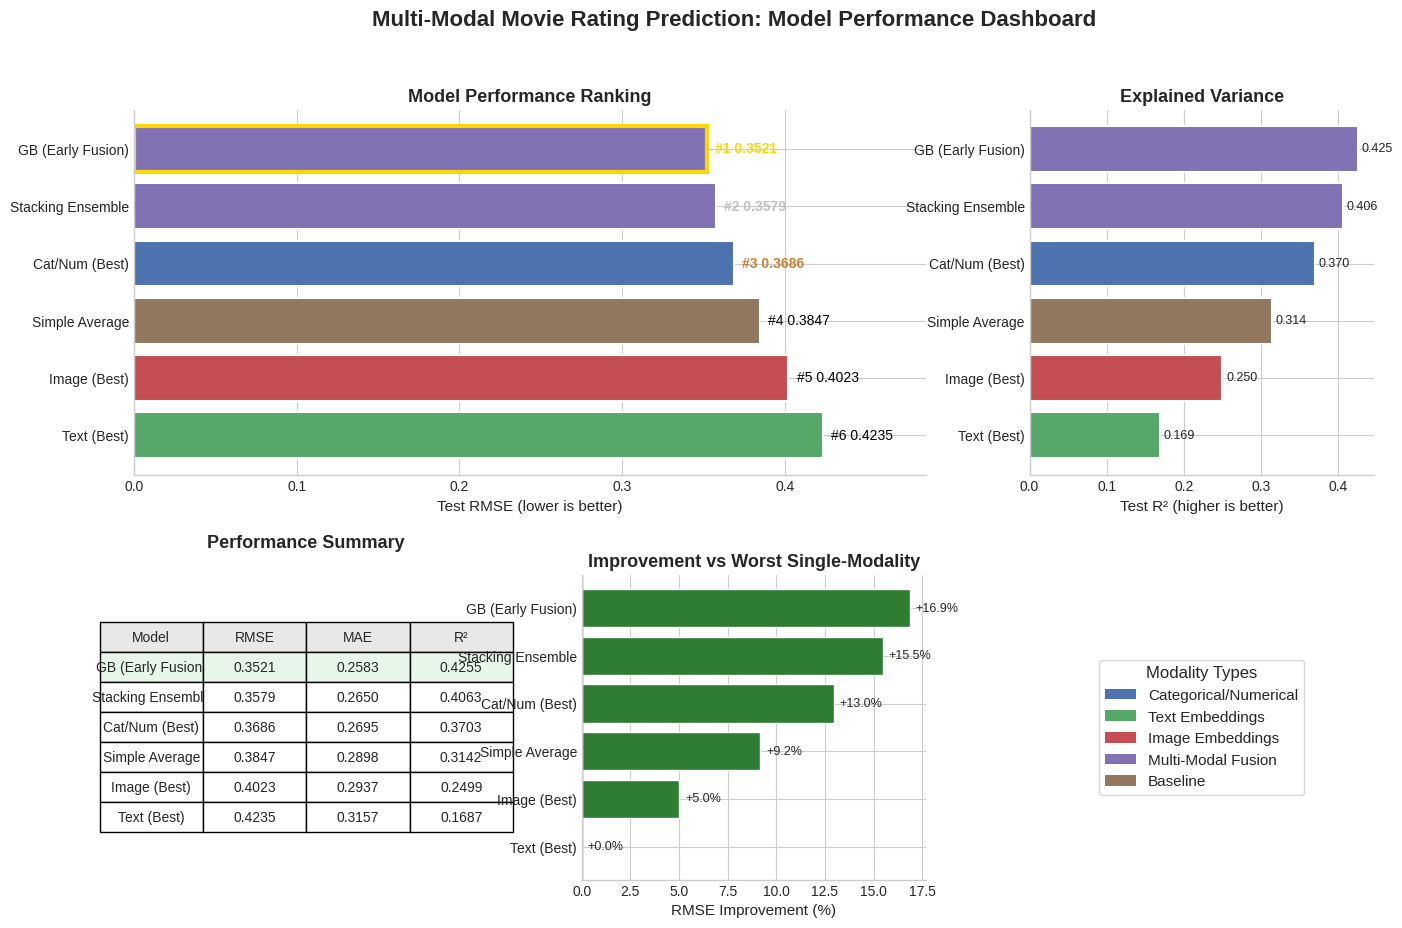

Saved prediction analysis to prediction_analysis.png


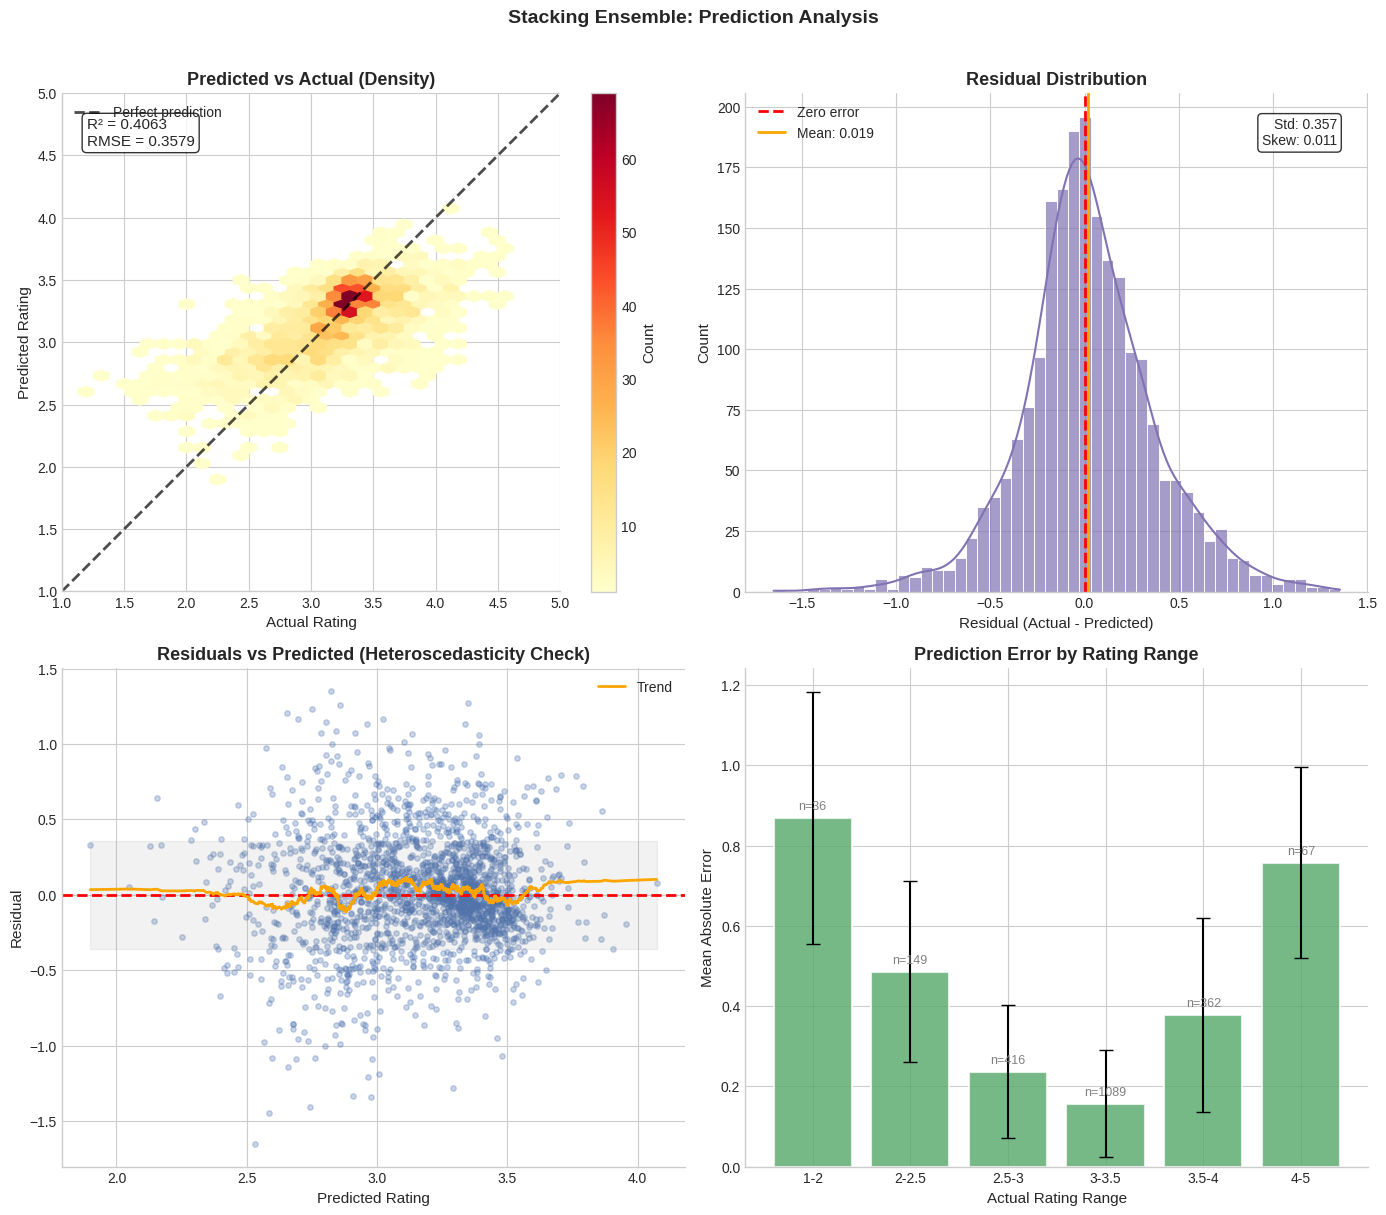

Saved modality contribution plot to modality_contribution.png


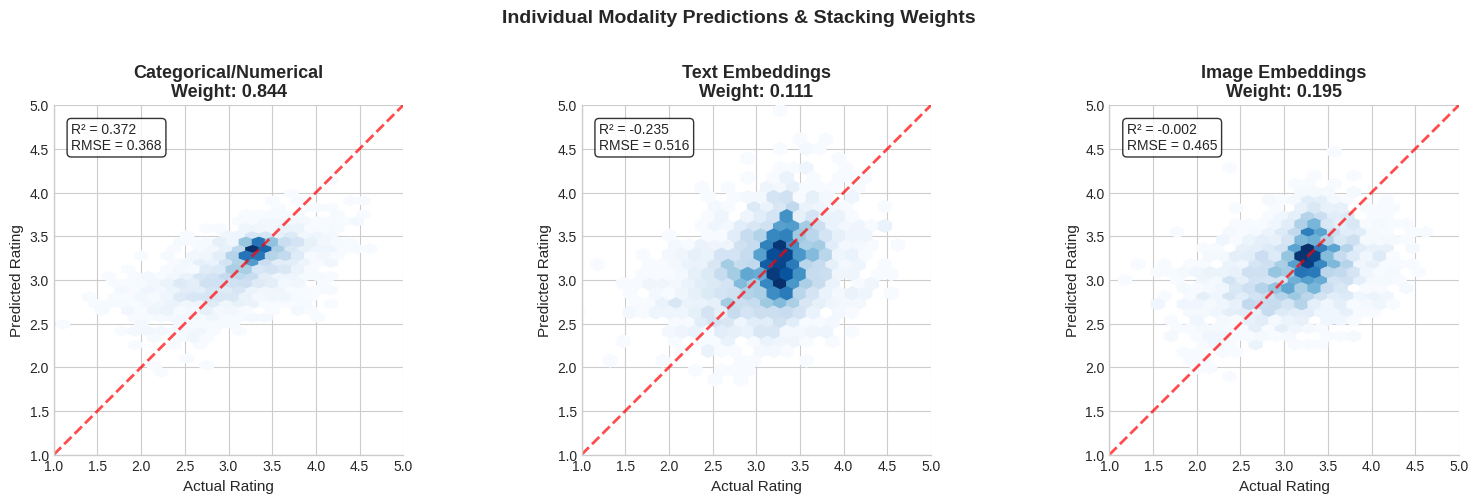

Saved summary slide to summary_slide.png


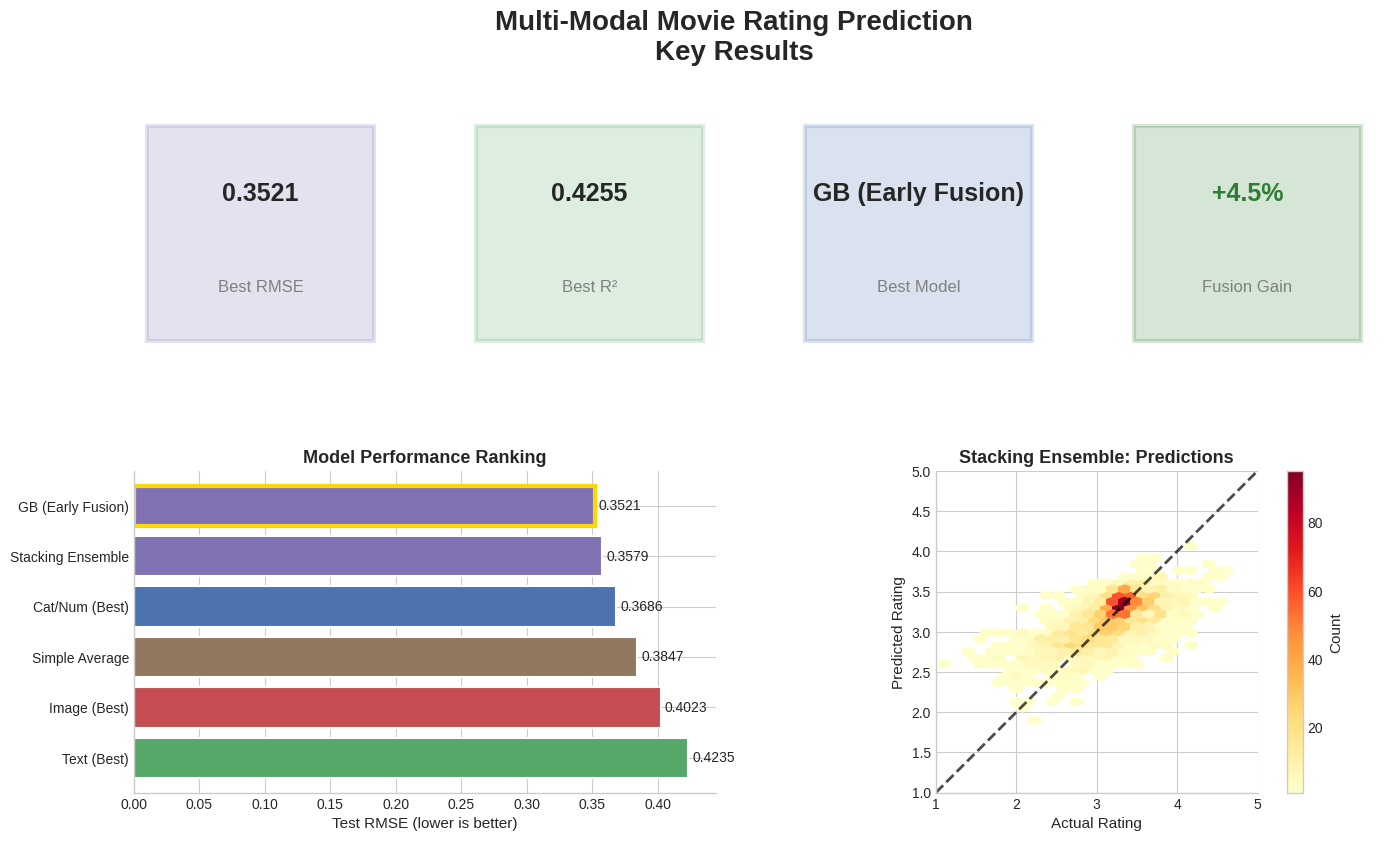

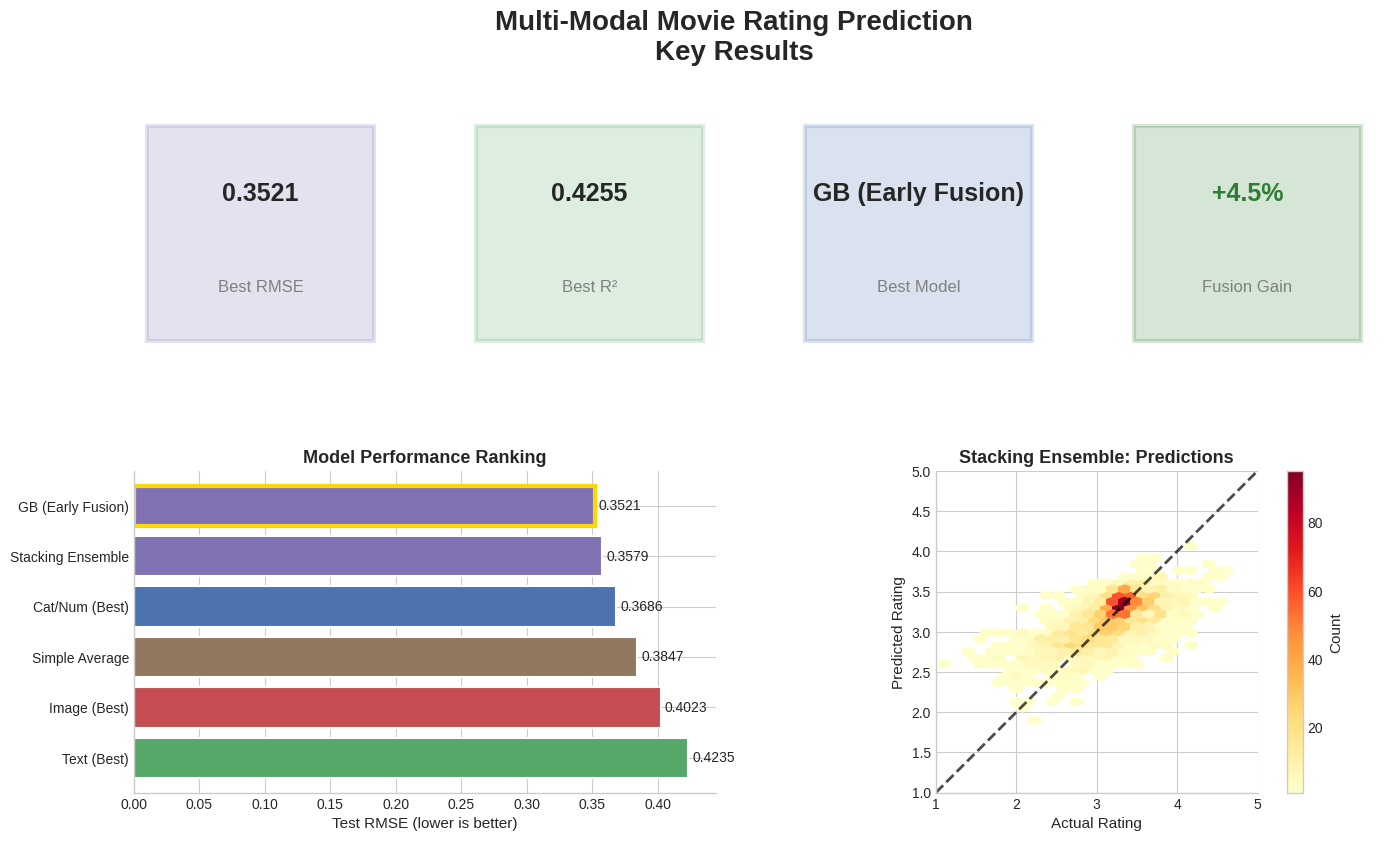

In [24]:

from plotting import (
plot_model_comparison_dashboard,
plot_predictions_analysis,
plot_modality_contribution,
create_summary_slide
)

plot_model_comparison_dashboard(all_results, "model_dashboard.png")
plot_predictions_analysis(y_test, y_pred_stack, 'Stacking Ensemble', "prediction_analysis.png")
plot_modality_contribution(individual_preds, y_test, meta_model.coef_, "modality_contribution.png")
create_summary_slide(all_results, 'Stacking Ensemble', y_pred_stack, y_test, "summary_slide.png")
